# Hybrid quantum-classical auto encoder 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ===================================================================================
#                       Create Data
# ===================================================================================

num_train = 7
num_test = 20
len_vector = 7

np.random.seed(1)
x_train = torch.tensor(np.random.rand(num_train, len_vector), dtype=torch.float32)
x_test = torch.tensor(np.random.rand(num_test, len_vector), dtype=torch.float32)

In [3]:
# ===================================================================================
#                       Classical Layers using PyTorch Sequential
# ===================================================================================

# Define first layer, hidden layers, and output layer with the output of two neurons

model = nn.Sequential(
            nn.Linear(7, 14),  # First layer with 7 inputs and 14 outputs
            nn.ReLU(),         # Activation function
            nn.Linear(14, 28), # Second layer with 14 inputs and 28 outputs
            nn.ReLU(),         # Activation function
            nn.Linear(28, 56), # Third layer with 28 inputs and 56 outputs
            nn.ReLU(),         # Activation function
            nn.Linear(56, 28), # Fourth layer reducing from 56 to 28 outputs
            nn.ReLU(),         # Activation function
            nn.Linear(28, 14), # Fifth layer reducing from 28 to 14 outputs
            nn.ReLU(),         # Activation function
            nn.Linear(14, 7)           
        )

In [4]:
# ===================================================================================
#                                Quantum Layer
# ===================================================================================

num_modes = 7
num_basis = 7

dev = qml.device("strawberryfields.fock", wires=num_modes, cutoff_dim=num_basis)

class QuantumLayer(nn.Module):
    def __init__(self, num_layers, num_modes):
        super().__init__()
        self.num_layers = num_layers
        self.num_modes = num_modes
        self.weights = nn.Parameter(torch.randn(num_layers, 5 * num_modes))

    def forward(self, x):
        def q_layer(v):
            qml.Rotation(v[0], wires=0)
            qml.Squeezing(v[1], 0.0, wires=0)
            qml.Rotation(v[2], wires=0)
            qml.Displacement(v[3], 0.0, wires=0)
            qml.Kerr(v[4], wires=0)
        
        @qml.qnode(dev, interface='torch')
        def quantum_nn(inputs, weights):
            # Assuming inputs is a tensor with shape [batch_size, 2]
            for i in range(inputs.shape[0]):
                qml.Displacement(inputs[i, 0].item(), inputs[i, 1].item(), wires=0)
            for v in weights:
                q_layer(v)
            return qml.probs(wires=0)
        
        # Clone and detach to ensure compatibility with PyTorch's computational graph
        x = x.clone().detach().requires_grad_(True)
        return quantum_nn(x, self.weights).float()

In [5]:
# ===================================================================================
#                             Hybrid Model
# ===================================================================================

num_layers = 25
num_modes = 1

qlayer = QuantumLayer(num_layers, num_modes)
#model.add_module("QuantumLayer", qlayer)

In [6]:
# ===================================================================================
#                                    Training
# ===================================================================================

opt = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.MSELoss()

# Initialize lists to store the history
loss_history = []
accuracy_history = []

from pyscf import gto, scf

# Define the loss function (energy expectation)
def energy_expectation(output, hamiltonian):
    # Your implementation here using PyTorch operations
    # Define the molecule

    # Convert Hamiltonian matrix to complex tensor
    H_complex = torch.tensor(hamiltonian, dtype=torch.cfloat).real

    wavefunction = output  # Assuming this is a complex tensor
    wavefunction_np = wavefunction.detach().numpy()
    expectation_value = np.dot(wavefunction_np, np.dot(hamiltonian, wavefunction_np))

    # Normalize the wavefunction
    norm_wavefunction = wavefunction / torch.sqrt(torch.sum(torch.abs(wavefunction)**2))

    # Check if the size of the Hamiltonian matches the size of the wavefunction
    # This is crucial, and you need to address this if there's a mismatch
    assert H_complex.shape[0] == norm_wavefunction.shape[0], "Size mismatch between Hamiltonian and wavefunction"

    # Calculate the energy expectation value
    energy = torch.vdot(norm_wavefunction, torch.mv(H_complex, norm_wavefunction)).real


    return energy #torch.tensor([0.0], requires_grad=True)  # Example placeholder

mol = gto.M(atom=[
    ['O', (0.0, 0.0, 0.0)],          # Oxygen at origin
    ['H', (0.0, -0.757, 0.587)],     # Hydrogen 1
    ['H', (0.0, 0.757, 0.587)]       # Hydrogen 2
], basis='sto-3g')
# Perform Hartree-Fock calculation
mf = scf.RHF(mol)
mf.kernel()



# Define a function to calculate accuracy (replace this with your accuracy calculation method)
def calculate_accuracy(y_pred, y_true):
    # Dummy accuracy calculation: replace with your actual accuracy calculation
    # For example, you could define accuracy as the percentage of predictions within a certain range of the actual values
    return torch.mean((y_pred - y_true).abs() / y_true.abs()).item()

for epoch in range(10):
    print(epoch)
    opt.zero_grad()
    output = model(x_train)
    print(output.shape)
    loss = abs(abs(energy_expectation(output, mf.get_hcore())) - abs(-74.9630631297277)) / abs(-74.9630631297277)
    loss.backward()
    opt.step()
    accuracy = calculate_accuracy(output, x_train)
    
    # Append loss and accuracy to their respective lists
    loss_history.append(loss.item())
    accuracy_history.append(accuracy)
    print(f"Epoch {epoch+1}, Loss: {loss.item()}, Accuracy: {accuracy}")



converged SCF energy = -74.9630631297277
0
torch.Size([7, 7])


RuntimeError: vector + matrix @ vector expected, got 1, 2, 2

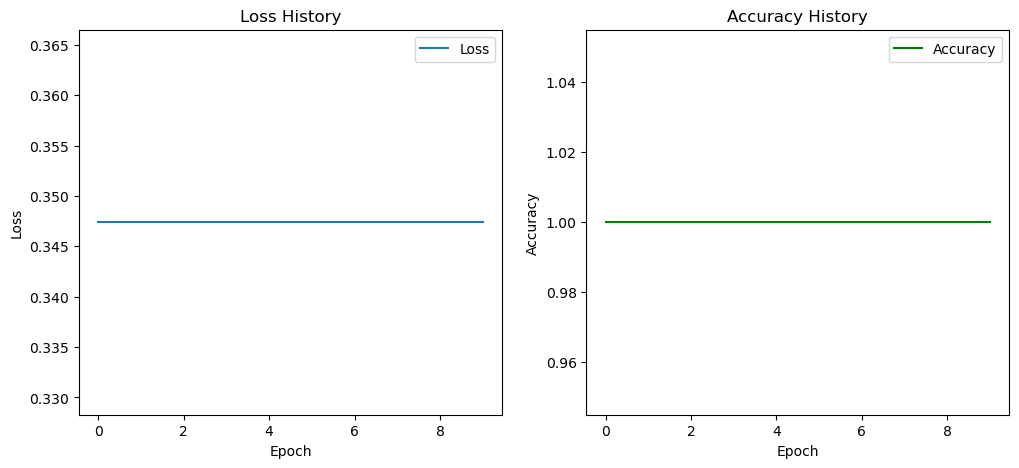

In [ ]:
# Plotting
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Accuracy', color='green')
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
from qiskit_nature.second_q.drivers import PySCFDriver
import torch
from pyscf import gto, scf

In [ ]:
# Define the molecule
mol = gto.M(atom=[
    ['O', (0.0, 0.0, 0.0)],          # Oxygen at origin
    ['H', (0.0, -0.757, 0.587)],     # Hydrogen 1
    ['H', (0.0, 0.757, 0.587)]       # Hydrogen 2
], basis='sto-3g')
# Perform Hartree-Fock calculation
mf = scf.RHF(mol)
mf.kernel()

converged SCF energy = -74.9630631297277


-74.96306312972766

In [ ]:
from pyscf import gto, scf

# Define the molecule
mol = gto.M(atom=[
    ['O', (0.0, 0.0, 0.0)],          # Oxygen at origin
    ['H', (0.0, -0.757, 0.587)],     # Hydrogen 1
    ['H', (0.0, 0.757, 0.587)]       # Hydrogen 2
], basis='sto-3g')

# Perform Hartree-Fock calculation
mf = scf.RHF(mol)
mf.kernel()

# Print the total energy
print("The total energy is: ", mf.e_tot)

converged SCF energy = -74.9630631297277
The total energy is:  -74.96306312972766


In [ ]:
import torch
import numpy as np

# Final output wavefunction as a tensor
wavefunction = torch.tensor([0.0098, 0.3599, -0.1368, 0.2739, 0.1338, -0.1375, 0.2118])

# Hamiltonian matrix
hamiltonian_matrix = np.array([
    [-3.27200969e+01, -7.61261083e+00,  0.00000000e+00,  0.00000000e+00, -1.89964386e-02, -1.74653142e+00, -1.74653142e+00],
    [-7.61261083e+00, -9.33406903e+00,  0.00000000e+00,  0.00000000e+00, -2.23504522e-01, -3.73681754e+00, -3.73681754e+00],
    [ 0.00000000e+00,  0.00000000e+00, -7.45704337e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
    [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -7.61289452e+00,  0.00000000e+00,  2.02705209e+00, -2.02705209e+00],
    [-1.89964386e-02, -2.23504522e-01,  0.00000000e+00,  0.00000000e+00, -7.55075521e+00, -1.64481726e+00, -1.64481726e+00],
    [-1.74653142e+00, -3.73681754e+00,  0.00000000e+00,  2.02705209e+00, -1.64481726e+00, -5.07392189e+00, -1.60715605e+00],
    [-1.74653142e+00, -3.73681754e+00,  0.00000000e+00, -2.02705209e+00, -1.64481726e+00, -1.60715605e+00, -5.07392189e+00]
])

# Convert wavefunction to numpy array for matrix operations
wavefunction_np = wavefunction.detach().numpy()

# Calculate the expectation value
# The expectation value is calculated as the dot product of the wavefunction, Hamiltonian, and wavefunction
expectation_value = np.dot(wavefunction_np, np.dot(hamiltonian_matrix, wavefunction_np))

print("Expectation Value:", expectation_value)


Expectation Value: -2.9861970147668178


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from classical_encoder import ClassicalEncoder
from classical_decoder import ClassicalDecoder
from QuantumCircuit import run_quantum_circuit

class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.encoder = ClassicalEncoder()
        self.decoder = ClassicalDecoder()
        self.qcircuit = run_quantum_circuit

    def forward(self, x):
        encoded = self.encoder(x)
        quantum_result = self.qcircuit(encoded)
        decoded = self.decoder(quantum_result)
        return decoded

# Initialize the model
model = HybridModel()

from pyscf import gto, scf

# Define the loss function (energy expectation)
def energy_expectation(output, hamiltonian):
    # Your implementation here using PyTorch operations
    # Define the molecule

    # Convert Hamiltonian matrix to complex tensor
    H_complex = torch.tensor(hamiltonian, dtype=torch.cfloat).real

    wavefunction = output  # Assuming this is a complex tensor
    wavefunction_np = wavefunction.detach().numpy()
    expectation_value = np.dot(wavefunction_np, np.dot(hamiltonian, wavefunction_np))

    # Normalize the wavefunction
    norm_wavefunction = wavefunction / torch.sqrt(torch.sum(torch.abs(wavefunction)**2))

    # Check if the size of the Hamiltonian matches the size of the wavefunction
    # This is crucial, and you need to address this if there's a mismatch
    assert H_complex.shape[0] == norm_wavefunction.shape[0], "Size mismatch between Hamiltonian and wavefunction"

    # Calculate the energy expectation value
    energy = torch.vdot(norm_wavefunction, torch.mv(H_complex, norm_wavefunction)).real


    return energy #torch.tensor([0.0], requires_grad=True)  # Example placeholder

# Sample input
#input_data = torch.rand(7, requires_grad=True)  # Example input
input_data= torch.tensor([ 0.3679, -0.0602,  0.6200,  0.1083, -0.0054,  0.0107,  0.1241])

# Optimization setup
print("The model parameters are: ", model.parameters)

optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 200
loss_values = []
mol = gto.M(atom=[
    ['O', (0.0, 0.0, 0.0)],          # Oxygen at origin
    ['H', (0.0, -0.757, 0.587)],     # Hydrogen 1
    ['H', (0.0, 0.757, 0.587)]       # Hydrogen 2
], basis='sto-3g')
# Perform Hartree-Fock calculation
mf = scf.RHF(mol)
mf.kernel()

for epoch in range(num_epochs):
    optimizer.zero_grad()            # Clear existing gradients
    output = model(input_data)       # Forward pass

    # Ensure output requires grad
    if not output.requires_grad:
        raise RuntimeError("Output does not require gradients. Check model implementation.")

    # Calculate the loss
    #initial_hamiltonian = hamiltonian_initial_module.mf.get_hcore()
    #final_hamiltonian = hamiltonian_final_module.mf.get_hcore()
    loss = abs(abs(energy_expectation(output, mf.get_hcore())) - abs(-74.9630631297277)) / abs(-74.9630631297277)

    # Check if loss requires grad
    if not loss.requires_grad:
        raise RuntimeError("Loss does not require gradients. Check energy_expectation implementation.")

    loss.backward()                  # Backward pass
    optimizer.step()                 # Update parameters
    loss_values.append(loss.item())  # Store loss for plotting
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


The model parameters are:  <bound method Module.parameters of HybridModel(
  (encoder): ClassicalEncoder(
    (fc): Sequential(
      (0): Linear(in_features=7, out_features=14, bias=True)
      (1): ReLU()
      (2): Linear(in_features=14, out_features=28, bias=True)
      (3): ReLU()
      (4): Linear(in_features=28, out_features=56, bias=True)
      (5): ReLU()
      (6): Linear(in_features=56, out_features=28, bias=True)
      (7): ReLU()
      (8): Linear(in_features=28, out_features=14, bias=True)
      (9): ReLU()
      (10): Linear(in_features=14, out_features=4, bias=True)
    )
  )
  (decoder): ClassicalDecoder(
    (fc): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=16, bias=True)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=32, bias=True)
      (5): ReLU()
      (6): Linear(in_features=32, out_features=16, bias=True)
      (7): ReLU()
      (8): Linear(in_features=1

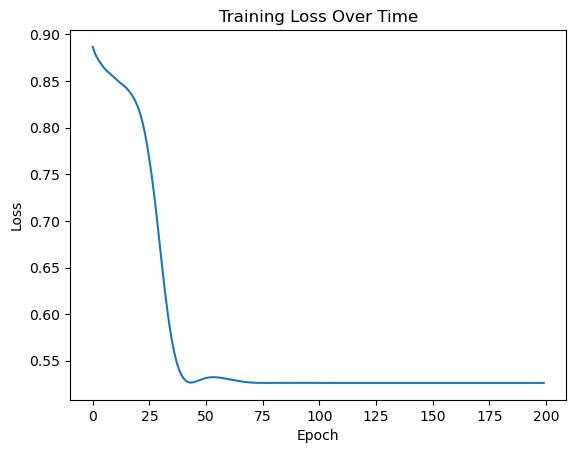

In [2]:
# Plotting the loss values
import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

In [2]:
print("The model parameters are: ", model.parameters)


The model parameters are:  <bound method Module.parameters of HybridModel(
  (encoder): ClassicalEncoder(
    (fc): Sequential(
      (0): Linear(in_features=7, out_features=14, bias=True)
      (1): ReLU()
      (2): Linear(in_features=14, out_features=28, bias=True)
      (3): ReLU()
      (4): Linear(in_features=28, out_features=56, bias=True)
      (5): ReLU()
      (6): Linear(in_features=56, out_features=28, bias=True)
      (7): ReLU()
      (8): Linear(in_features=28, out_features=14, bias=True)
      (9): ReLU()
      (10): Linear(in_features=14, out_features=4, bias=True)
    )
  )
  (decoder): ClassicalDecoder(
    (fc): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=16, bias=True)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=32, bias=True)
      (5): ReLU()
      (6): Linear(in_features=32, out_features=16, bias=True)
      (7): ReLU()
      (8): Linear(in_features=1